In [106]:
import pandas as pd
import numpy as np
import warnings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
import pickle
from script import create_time_series
from fsrs_optimizer import Optimizer, Trainer
from fsrs_optimizer import Collection, power_forgetting_curve, rmse_matrix
from collections import defaultdict
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

lr: float = 4e-2
n_epoch: int = 5
batch_size: int = 512
# look_ahead: int = 100  # Number of reviews between optimisations. Moved to the function call
verbose: bool = False
optimizer = Optimizer()
cache = None

def get_res_cached(file, look_ahead):
    global cache
    if cache is None:
        try:
            with open('minimum_limit_cache.pckl', 'rb') as f:
                cache = pickle.load(f)
        except FileNotFoundError:
            print("No cache found")
            cache = {}
    if (file, look_ahead) in cache:
        return cache[(file, look_ahead)]
    return None

def add_to_cache(key, value):
    global cache
    assert cache is not None
    cache[key] = value
    if len(cache) % 50 == 0:
        save_cache()
        print("Cache saved")

def save_cache():
    global cache
    with open('minimum_limit_cache_temp.pckl', 'wb') as f:
        pickle.dump(cache, f)
    try:
        os.remove('minimum_limit_cache.pckl')
    except FileNotFoundError:
        pass
    os.rename('minimum_limit_cache_temp.pckl', 'minimum_limit_cache.pckl')

def plot_file(file, look_ahead, cumulative_data=None, plot_individual=False, plot_cumulative=False, look_aheads=None):
    global cache
    if cumulative_data is None:
        cumulative_data = [[], [], []]
    if look_aheads is None:
        look_aheads = [look_ahead]  # Can run extra lookaheads in the same call
    
    cache_res_all = [get_res_cached(file, this_look_ahead) for this_look_ahead in look_aheads]
    if None not in cache_res_all:
        cache_res = get_res_cached(file, look_ahead)
        assert cache_res is not None
        rmses, loglosses, indexes = cache_res
    else:
        dataset = pd.read_csv(file)[:5000]
        dataset = create_time_series(dataset).reset_index()
        optimized_list = []
        dry_run_list = []
        pretrain_list = []
        testsets_all = [[] for _ in range(len(look_aheads))]

        max_pow = np.floor(np.log2(len(dataset)))

        indexes = [2**i for i in range(3, int(max_pow) + 1)]
        indexes = [i for i in indexes if i <= 4096]
        # print(indexes)

        for max_index in indexes:
            train_set = dataset.loc[:max_index].copy()
            for i, look_ahead in enumerate(look_aheads):
                test_set = dataset.loc[max_index : min(max_index + look_ahead + 1, len(dataset) - 1)].copy()
                testsets_all[i].append(test_set)
            optimizer.define_model()
            dry_run_list.append(optimizer.init_w.copy())

            optimizer.S0_dataset_group = (
                train_set[train_set["i"] == 2]
                .groupby(by=["r_history", "delta_t"], group_keys=False)
                .agg({"y": ["mean", "count"]})
                .reset_index()
            )
            _ = optimizer.pretrain(dataset=train_set, verbose=verbose)
            pretrain_list.append(optimizer.init_w.copy())

            try:
                trainer = Trainer(
                    train_set,
                    None,
                    optimizer.init_w,
                    n_epoch=n_epoch,
                    lr=lr,
                    batch_size=batch_size,
                )
                optimized_list.append(trainer.train(verbose=verbose))
            except Exception as e:
                if str(e) != "Training data is inadequate.":
                    print(e)
                optimized_list.append(optimizer.init_w.copy())

        for look_ahead, testsets in zip(look_aheads, testsets_all):
            rmses = defaultdict(list)
            loglosses = defaultdict(list)
            for i, (w1, w2, w3, testset) in enumerate(zip(optimized_list, pretrain_list, dry_run_list, testsets)):
                for j, w in enumerate((w1, w2, w3)):
                    my_collection = Collection(w)
                    stabilities, difficulties = my_collection.batch_predict(testset)
                    testset["p"] = power_forgetting_curve(testset["delta_t"], stabilities)
                    rmse = rmse_matrix(testset)
                    rmses[j].append(rmse)
                    logloss = log_loss(testset["y"], testset["p"], labels=[0, 1])
                    loglosses[j].append(logloss)

            add_to_cache((file, look_ahead), (rmses, loglosses, indexes))

        cache_res = get_res_cached(file, look_ahead)
        assert cache_res is not None
        rmses, loglosses, indexes = cache_res

    if plot_individual:
        plt.plot(indexes, rmses[0], label="optimised")
        plt.plot(indexes, rmses[1], label="pretrain")
        plt.plot(indexes, rmses[2], label="dry_run")
        plt.title("RMSE")
        plt.ylim(0, max(rmses[0] + rmses[1] + rmses[2]))
        plt.semilogx()
        plt.legend()
        plt.show()

    # Cumulative version
    cumulative_data[0].append(rmses[0])
    cumulative_data[1].append(rmses[1])
    cumulative_data[2].append(rmses[2])
    cumulative_means = [[], [], []]
    cumulative_vals = [[], [], []]
    for i in range(3):
        this_vals = [[] for _ in range(len(indexes))]
        for this_rmses in cumulative_data[i]:
            for j, rmse in enumerate(this_rmses):
                if j >= len(indexes):
                    break
                this_vals[j].append(rmse)
        for j in range(len(indexes)):
            cumulative_means[i].append(np.mean(this_vals[j]))
            cumulative_vals[i].append(this_vals[j])

    if plot_cumulative:
        print("""
Very important note:
    With a low lookahead, i.e. frequent optimisation, pretrain does great on even n=8.
    The issue is that we can't plot the IQR of this easily, or rather it's meaning is limited.
    For example, if we were plotting accuracy instead of loss, and we used lookahead=1 (ideal lookahead - how well does optimised FSRS perform immediately after optimisation), we would have an IQR between 0 and 1. Every accuracy is 0% or 100%.
              
    For the graphs in metric_over_size.ipynb:   n=8 has lookahead 3.    Hence we have issues plotting the IQR, but the mean is very accurate and shows good results.
    For the first set of graphs:                n=8 has lookahead 10.   Hence, IQR will be more representative of the actual results, but all test losses will be less accurate as we aren't optimising for a while.
    For the second set of graphs:               n=8 has lookahead 100.  IQR is now less representative because we're optimising on 8 reviews then testing on 100 (100 reviews with a single optimisation after 8 reviews!). The test losses aren't very accurate because of this.
    For the third set of graphs:                n=8 has lookahead 1000. The losses of n=8 are now meaningless. (1000 reviews with a single optimisation after 8 reviews!)
              
    To summarise: The analyses suggest pretrain works great on all n. It's just hard to show it through IQR because a larger test dataset means less accurate losses. Lookahead 10 shows it quite well, and mean log loss vs mean rmse shows it even better. (Log loss penalises being very wrong more than RMSE).
""")
        plt.plot(indexes, cumulative_means[0], label="optimised")
        plt.plot(indexes, cumulative_means[1], label="pretrain")
        plt.plot(indexes, cumulative_means[2], label="dry_run")

        # Shade between IQR
        for i in range(3):
            plt.fill_between(indexes, [np.percentile(e, 25, axis=0) for e in cumulative_vals[i]], [np.percentile(e, 75, axis=0) for e in cumulative_vals[i]], alpha=0.2)  # type: ignore

        plt.title(f"Averaged RMSE over {len(cumulative_data[0])} collection" + ('s' if len(cumulative_data[0]) > 1 else '') + f" with lookahead {look_ahead}")
        plt.ylim(0, max(cumulative_means[0] + cumulative_means[1] + cumulative_means[2]))
        plt.semilogx()
        plt.legend()
        plt.show()

        # Plot differences
        for i, (model_i, model_compare_i) in enumerate([(0,2), (1,2), (0,1)]):
            plt.figure()

            diffs = [np.array(cumulative_vals[model_compare_i][j]) - np.array(cumulative_vals[model_i][j]) for j in range(len(indexes))]
            diffs_means = [np.mean(e) for e in diffs]
            diffs_lower = [np.percentile(e, 25) for e in diffs]
            diffs_upper = [np.percentile(e, 75) for e in diffs]
            plt.plot(indexes, diffs_means)
            plt.fill_between(indexes, diffs_lower, diffs_upper, alpha=0.3)  # type: ignore

            # Dotted line at y=0
            plt.plot([indexes[0], indexes[-1]], [0, 0], 'k--')

            # Set limits so y=0 is centred
            plt.ylim(-max([abs(e) for e in diffs_lower+diffs_upper]), max([abs(e) for e in diffs_lower+diffs_upper]))

            plt.title(f"How much better {['optimised', 'pretrain', 'dry_run'][model_i]} is than {['optimised', 'pretrain', 'dry_run'][model_compare_i]}")
            plt.semilogx()
            plt.show()

    return (rmses[0], rmses[1], rmses[2]), cumulative_data

Graph 300 
Very important note:
    With a low lookahead, i.e. frequent optimisation, pretrain does great on even n=8.
    The issue is that we can't plot the IQR of this easily, or rather it's meaning is limited.
    For example, if we were plotting accuracy instead of loss, and we used lookahead=1 (ideal lookahead - how well does optimised FSRS perform immediately after optimisation), we would have an IQR between 0 and 1. Every accuracy is 0% or 100%.
              
    For the graphs in metric_over_size.ipynb:   n=8 has lookahead 3.    Hence we have issues plotting the IQR, but the mean is very accurate and shows good results.
    For the first set of graphs:                n=8 has lookahead 10.   Hence, IQR will be more representative of the actual results, but all test losses will be less accurate as we aren't optimising for a while.
    For the second set of graphs:               n=8 has lookahead 100.  IQR is now less representative because we're optimising on 8 reviews then tes

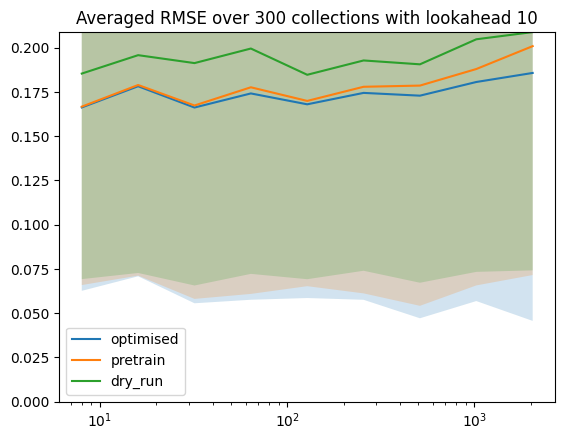

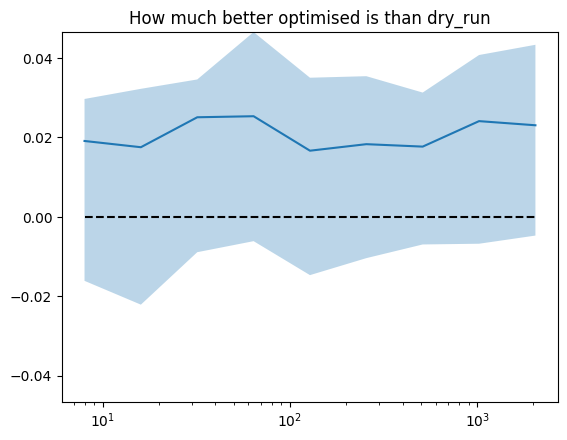

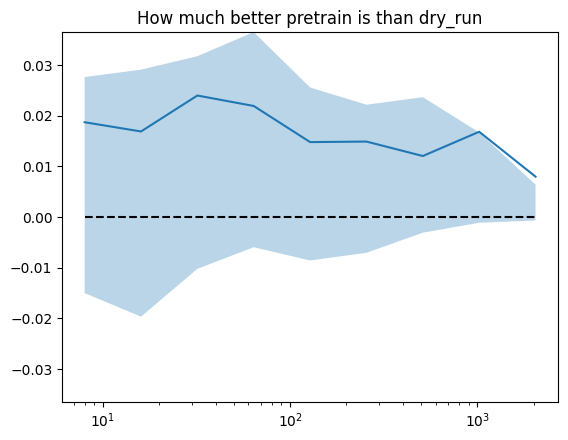

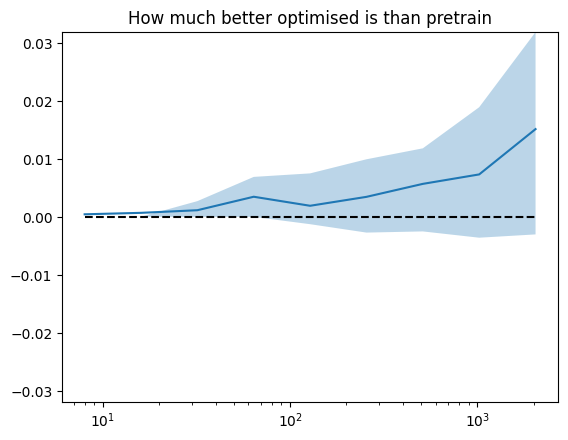

In [107]:
cumulative_data = [[], [], []]
for i in range(300):
    print('\rGraph', i+1, '', end='')
    _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=10, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=i==299, look_aheads=[10,100,1000])
save_cache()

Graph 300 
Very important note:
    With a low lookahead, i.e. frequent optimisation, pretrain does great on even n=8.
    The issue is that we can't plot the IQR of this easily, or rather it's meaning is limited.
    For example, if we were plotting accuracy instead of loss, and we used lookahead=1 (ideal lookahead - how well does optimised FSRS perform immediately after optimisation), we would have an IQR between 0 and 1. Every accuracy is 0% or 100%.
              
    For the graphs in metric_over_size.ipynb:   n=8 has lookahead 3.    Hence we have issues plotting the IQR, but the mean is very accurate and shows good results.
    For the first set of graphs:                n=8 has lookahead 10.   Hence, IQR will be more representative of the actual results, but all test losses will be less accurate as we aren't optimising for a while.
    For the second set of graphs:               n=8 has lookahead 100.  IQR is now less representative because we're optimising on 8 reviews then tes

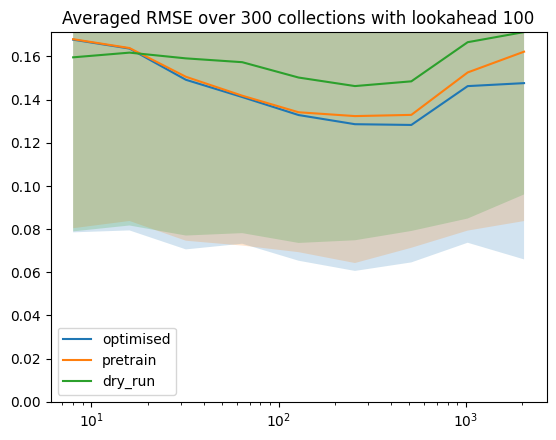

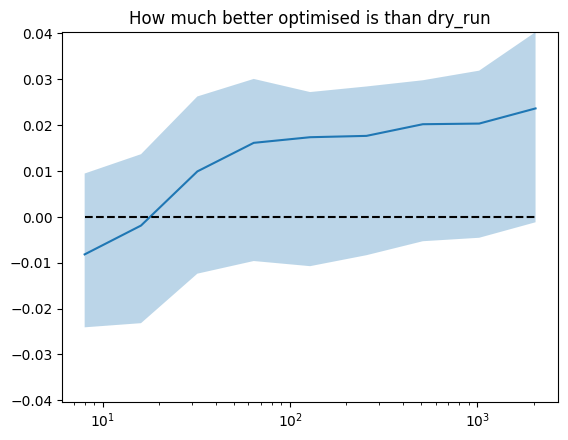

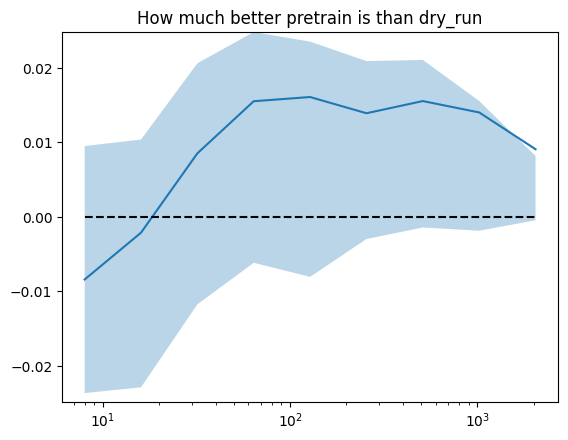

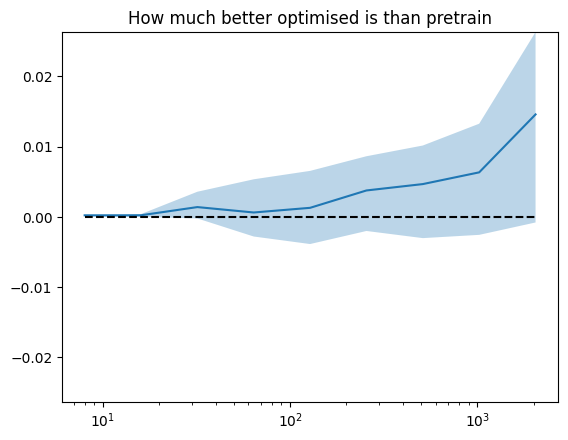

In [108]:
cumulative_data = [[], [], []]
for i in range(300):
    print('\rGraph', i+1, '', end='')
    _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=100, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=i==299, look_aheads=[10,100,1000])
save_cache()

Graph 300 
Very important note:
    With a low lookahead, i.e. frequent optimisation, pretrain does great on even n=8.
    The issue is that we can't plot the IQR of this easily, or rather it's meaning is limited.
    For example, if we were plotting accuracy instead of loss, and we used lookahead=1 (ideal lookahead - how well does optimised FSRS perform immediately after optimisation), we would have an IQR between 0 and 1. Every accuracy is 0% or 100%.
              
    For the graphs in metric_over_size.ipynb:   n=8 has lookahead 3.    Hence we have issues plotting the IQR, but the mean is very accurate and shows good results.
    For the first set of graphs:                n=8 has lookahead 10.   Hence, IQR will be more representative of the actual results, but all test losses will be less accurate as we aren't optimising for a while.
    For the second set of graphs:               n=8 has lookahead 100.  IQR is now less representative because we're optimising on 8 reviews then tes

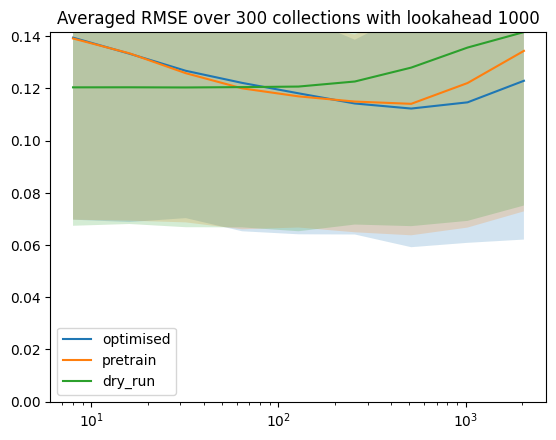

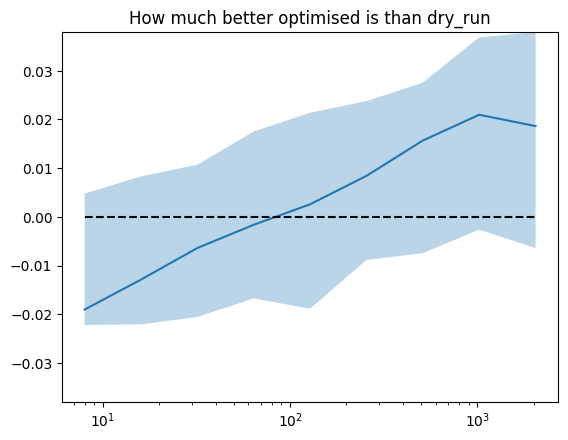

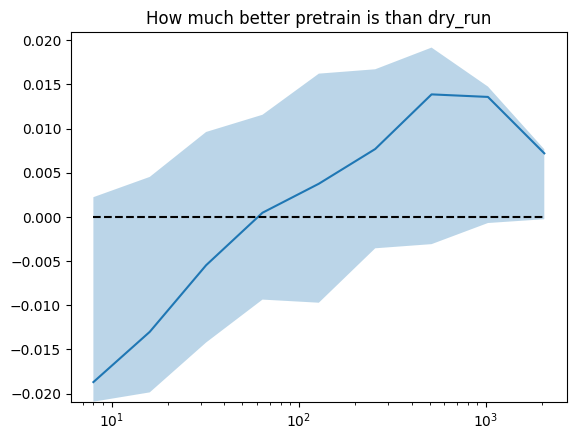

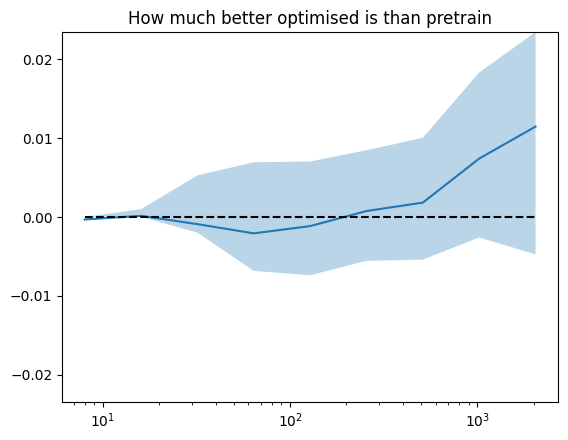

In [109]:
cumulative_data = [[], [], []]
for i in range(300):
    print('\rGraph', i+1, '', end='')
    _, cumulative_data = plot_file(f'../dataset/FSRS-Anki-20k/dataset/1/{i+1}.csv', look_ahead=1000, cumulative_data=cumulative_data, plot_individual=False, plot_cumulative=i==299, look_aheads=[10,100,1000])
save_cache()